# Starbucks Challenge


# Project Overview

In this project we will analyze and combine transaction, demographic and offer data from Starbucks' mobile app to determine whether or not to send an offer to a user, and specify the attributes that affects that decision.

## Problem Statement

Starbucks send a lot of offers to their users, some users receive the offer, view it, and make a purchase, thus they are influenced by the offer, however, others make purchases without offers, so we should exclude them from our offers.

### Strategy

**1. We will analyze data and drive meaningful insights from it, like:**

- Reward (Average & Maximum  offer reward)
- Difficulty (Average & Maximum offer difficulty)
- Duration (Average & Longest offer period)


- Offers' types distribution.
- The most frequent way used to send an offer.
- The year that had most new users.
- Age groups of users and their distribution within our users base.
- Average age and income of each gender.
- Gender of most users.


- Average number of users who get offers in a week.
- Average number of users who receive a particular offer (offer 1 or offer 2 etc.)
- Gender of users who complete offers.
- Highest average income's gender.
- Most completed offer.
- Offers types that influence users the most.
- Preferred offer type for each age group.

    Recommendations regarding this analysis are given along the way.

**2. We will extract users who (were sent offers & viewed them & completed offers), give them label 1, and extract users who weren't sent offers but still made purchases, give them label 0.**


**3. Build a ML model to classify users to determine whether to send offers to each one, and assess that model's performance on testing set, and see which features contribute the most to our decision. (will use f1-score as a metric).**

## About Data

This dataset contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 


Not all users receive the same offer, and that is the challenge to solve with this data set.

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Data has transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

### Example

A user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

#### Caution
A user can receive an offer, never actually view the offer, and still complete the offer. 

For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Notebook Phases

**After reading data, each dataset will go through 3 phases:**
1. Data Exploration
2. Data Preparation
3. Data Visualization

**Then**
- Constructing modeling data, building and evaluating a **RandomForestClassifier.**
    - Features: ['age', 'income', 'sent_offer', 'F', 'M', 'O', '2013.0', '2014.0',
       '2015.0', '2016.0', '2017.0', '2018.0', 'child', 'teen', 'young adult',
       'adult', 'elderly']
- Results and possible improvements.

# Imports

In [1]:
import pandas as pd 
import numpy as np
import math
import json
import datetime
import re

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer

In [2]:
# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

# 1. Portfolio

## Data Exploration

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## checking for missing data

In [4]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

**Portfolio has 10 instances with no missing data!**

### Useful info about the portfolio dataset


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


#### Observations

- Reward
    - Average offer reward is approximately 4.
    - Maximum reward was 10.
- Difficulty
    - Average offer difficulty is approximately 8.
    - Maximum difficulty was 20.
- Duration
    - On average, an offer lasts for 6.5 days.
    - The longest an offer last was for 10 day while the shortest lasted for only 3 days.

In [7]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

### Splitting offers channels

In [8]:
def split_channels(portfolio):
    '''
    INPUTS:
    
    portfolio: dataframe to do operation on
    
    RETURNS:
    
    portfolio: dataframe after splitting channels
    
    '''
    
    # get channels values
    channels_set = set()
    for i in portfolio.channels:
        channels_set.update(set(i))
     
    # splitting the channels into different columns
    for i in channels_set:
        portfolio[i] = portfolio.channels.apply(lambda x : i in x).map({True: 1, False:0})
        
    portfolio.drop('channels',axis=1,inplace=True)
    
    return portfolio 

In [9]:
portfolio = split_channels(portfolio)
portfolio


,reward,difficulty,duration,offer_type,id,mobile,email,web,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


### Examining offer channels

In [10]:
portfolio[['mobile', 'web', 'email', 'social']].sum().sort_values(ascending=False)

email     10
mobile     9
web        8
social     6
dtype: int64

#### Observations:

- All offers got promoted through emails.
- Most offers are advertised through mobile or web.
- 60% of the offers are through social.

In [11]:
# encoding offer ids for easier readings
offers = dict(zip(portfolio['id'], portfolio.index.values.tolist()))
offers

# encoding offers ids
# adding 1 to make them from 1:10 instead of 0:9 (simpler for human reading)
portfolio['id'] = portfolio['id'].apply(lambda x: offers[x]+1)
portfolio

,reward,difficulty,duration,offer_type,id,mobile,email,web,social
0,10,10,7,bogo,1,1,1,0,1
1,10,10,5,bogo,2,1,1,1,1
2,0,0,4,informational,3,1,1,1,0
3,5,5,7,bogo,4,1,1,1,0
4,5,20,10,discount,5,0,1,1,0
5,3,7,7,discount,6,1,1,1,1
6,2,10,10,discount,7,1,1,1,1
7,0,0,3,informational,8,1,1,0,1
8,5,5,5,bogo,9,1,1,1,1
9,2,10,7,discount,10,1,1,1,0


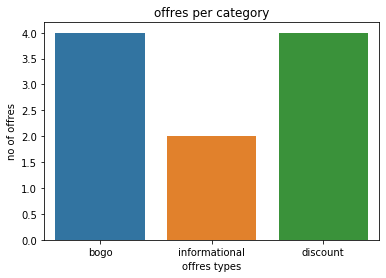

In [12]:
sns.countplot(x="offer_type", data=portfolio)
plt.title("offres per category")
plt.ylabel("no of offres")
plt.xlabel("offres types")
plt.show()

#### Observations:

**There are 4 BOGO offers, 4 discounts, and 2 informational offers.**

## Data exploration

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### Data preparation


#### Checking for mssing values

In [14]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
profile[profile.isnull()]

,gender,age,id,became_member_on,income
0,None,NaN,None,NaN,NaN
1,None,NaN,None,NaN,NaN
2,None,NaN,None,NaN,NaN
3,None,NaN,None,NaN,NaN
4,None,NaN,None,NaN,NaN
...,...,...,...,...,...
16995,NaN,NaN,NaN,NaN,NaN
16996,NaN,NaN,NaN,NaN,NaN
16997,NaN,NaN,NaN,NaN,NaN
16998,NaN,NaN,NaN,NaN,NaN


In [17]:
profile.dropna(inplace=True)
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

### Extracting year_joined column which has the year each user joined in

In [18]:
def getYear(x):
    """
    Inputs:
        x : date column in "%Y%m%d" format
    Returns:
        year the user joined in 
    """
    return datetime.datetime.strptime(str(x),"%Y%m%d").year

In [19]:
profile["year_joined"] = profile["became_member_on"].apply(lambda x : getYear(x))
profile.drop("became_member_on",inplace=True,axis=1)

### sanity check

In [20]:
profile.head()

,gender,age,id,income,year_joined
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


### Dividing users into different age groups: 'child', 'teen', 'young adult', 'adult' and 'elderly'

In [21]:
profile['age_group'] = pd.cut(profile.age,bins=[0,12,18,21,64,200],labels=['child', 'teen', 'young adult', 'adult', 'elderly'])
profile.head()

,gender,age,id,income,year_joined,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,adult
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,elderly
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,elderly
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,elderly
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,adult


In [22]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gender       14825 non-null  object  
 1   age          14825 non-null  int64   
 2   id           14825 non-null  object  
 3   income       14825 non-null  float64 
 4   year_joined  14825 non-null  int64   
 5   age_group    14825 non-null  category
dtypes: category(1), float64(1), int64(2), object(2)
memory usage: 709.6+ KB


In [23]:
print('Age Statistics:')
profile.groupby("gender").age.describe()

Age Statistics:


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,57.544950,16.883315,18.0,48.0,58.0,69.0,101.0
M,8484.0,52.116690,17.413894,18.0,39.0,53.0,65.0,100.0
O,212.0,54.400943,16.244710,20.0,43.0,55.0,66.0,100.0


In [24]:
print('Income Statistics:')
profile.groupby("gender").income.describe()

Income Statistics:


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0


In [25]:
profile.groupby(['age_group']).count()

,gender,age,id,income,year_joined
age_group,,,,,
child,0,0,0,0,0
teen,70,70,70,70,70
young adult,410,410,410,410,410
adult,10079,10079,10079,10079,10079
elderly,4266,4266,4266,4266,4266


#### Observations:

- Age group
    - Most users are adults, but some alderly people use the app as well.
- Age
    - Average age of female users is approximately 57.5 while the average for males is 52, other types' average is 54.
- Income
    - Females have the highest average income, followed by others, then males.

#### Number of new users per year

In [26]:
profile.groupby("year_joined").id.count().sort_values(ascending=False)

year_joined
2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: id, dtype: int64

#### Observations:

- Most users joined in 2017.
- Around 47% of the users joined in 2018 and 2016
- The least users joined in 2013

## Data Visualization

### Plotting new users each year

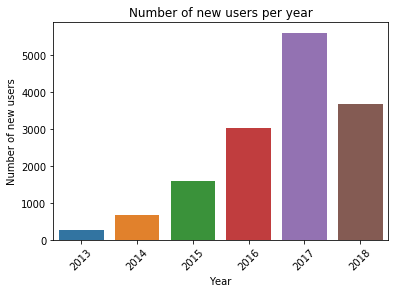

In [27]:
sns.countplot(x="year_joined", data = profile)
plt.title('Number of new users per year')
plt.ylabel('Number of new users')
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.show()

**The number of new users increased throughout the years and reached a peak of 5599 in 2017, then decreased in 2018 to 3669.**

### Age groups' visualization

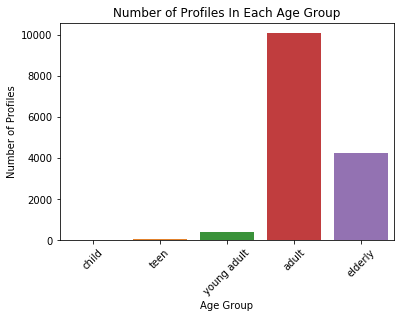

In [28]:
sns.countplot(x="age_group", data = profile)
plt.title('Number of Profiles In Each Age Group')
plt.ylabel('Number of Profiles')
plt.xlabel('Age Group')
plt.xticks(rotation = 45)
plt.show()

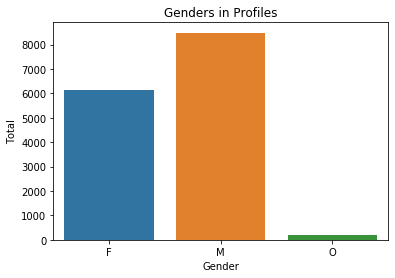

In [29]:
sns.countplot(x= "gender" , data= profile)
plt.title('Genders in Profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show()

#### Observations

- Most users are adults.
- Most users are males.
- 2017 had the most new users.

# 3. Transcript

## Data Exploration

In [30]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Data Preparation

### Checking for missing values

In [31]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

**It has no missing data**

### Extracting offer_id and other attributes from values column

In [32]:
def extract_values(col):
    '''
    
    INPUTS:
    
        col: column to extract values from
        
    RETURNS:
    
        transcript dataframe after extracting values
        
    '''

    attrubutes = []   
    
    # iterating through transcript to get attributes
    for idx, row in transcript.iterrows():
        for val in row['value']:
            if val not in attrubutes:
                attrubutes.append(val)
            
    
    # we have 4 attributes: 'offer id', 'amount', 'offer_id', 'reward'
    # but 'offer id' and 'offer_id' are the same, we will use the latter one
    # let's encode them..
    
    # initializing columns
    transcript['offer_id'] = ''
    transcript['amount'] = 0
    transcript['reward'] = 0
    
    # iterating over transcript table
    for idx, row in transcript.iterrows():
        for val in row['value']:
            # check value column and update it, put each key in seperated column.
            if val == 'offer_id' or val == 'offer id':
                transcript.at[idx, 'offer_id']= row['value'][val]
            else:
                 transcript.at[idx, str(val)]= row['value'][val]
    
    # drop value column
    transcript.drop('value', axis=1, inplace=True)
                
    return transcript # returning transcript

In [33]:
transcript = extract_values(transcript)

transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


### encoding offer_id as a number like we did previously

In [34]:
transcript['offer_id'] = transcript['offer_id'].apply(lambda x: offers[x]+1 if x else None) 

In [35]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,4.0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,10.0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,7.0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,2.0,0,0


### Useful info about transcript data


In [36]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   offer_id  167581 non-null  float64
 4   amount    306534 non-null  int64  
 5   reward    306534 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 14.0+ MB


In [37]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**There are a total of 138953 transactions, 76277 users who recieved offers, 57725 users who actually viewed the offer, and only 33579 who completed the offer but it's not nessecarily that all of them have acted upon the offer's influence.**

In [38]:
users_who_received_offers = transcript[(transcript['event'] == 'offer received')]
users_who_received_offers.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,4.0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,10.0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,7.0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,2.0,0,0


In [39]:
print("There are {} users who received offers".format(users_who_received_offers.shape[0]))

There are 76277 users who received offers


In [40]:
users_who_received_offers.groupby(['time', 'offer_id']).count()

person  event  amount  reward
time offer_id                               
0    1.0         1292   1292    1292    1292
     2.0         1218   1218    1218    1218
     3.0         1273   1273    1273    1273
     4.0         1245   1245    1245    1245
     5.0         1297   1297    1297    1297
     6.0         1221   1221    1221    1221
     7.0         1318   1318    1318    1318
     8.0         1266   1266    1266    1266
     9.0         1263   1263    1263    1263
     10.0        1257   1257    1257    1257
168  1.0         1319   1319    1319    1319
     2.0         1240   1240    1240    1240
     3.0         1266   1266    1266    1266
     4.0         1296   1296    1296    1296
     5.0         1245   1245    1245    1245
     6.0         1250   1250    1250    1250
     7.0         1250   1250    1250    1250
     8.0         1270   1270    1270    1270
     9.0         1263   1263    1263    1263
     10.0        1270   1270    1270    1270
336  1.0         1245   1245    1245    1245
     2.0         1280   1280    1280    1280
     3.0         1279   1279    1279    1279
     4.0         1275   1275    1275    1275
     5.0         1322   1322    1322    1322
     6.0         1301   1301    1301    1301
     7.0         1243   1243    1243    1243
     8.0         1256   1256    1256    1256
     9.0         1247   1247    1247    1247
     10.0        1263   1263    1263    1263
408  1.0         1278   1278    1278    1278
     2.0         1308   1308    1308    1308
     3.0         1275   1275    1275    1275
     4.0         1274   1274    1274    1274
     5.0         1269   1269    1269    1269
     6.0         1274   1274    1274    1274
     7.0         1222   1222    1222    1222
     8.0         1293   1293    1293    1293
     9.0         1250   1250    1250    1250
     10.0        1335   1335    1335    1335
504  1.0         1248   1248    1248    1248
     2.0         1310   1310    1310    1310
     3.0         1229   1229    1229    1229
     4.0         1261   1261    1261    1261
     5.0         1258   1258    1258    1258
     6.0         1286   1286    1286    1286
     7.0         1283   1283    1283    1283
     8.0         1238   1238    1238    1238
     9.0         1305   1305    1305    1305
     10.0        1286   1286    1286    1286
576  1.0         1276   1276    1276    1276
     2.0         1237   1237    1237    1237
     3.0         1295   1295    1295    1295
     4.0         1326   1326    1326    1326
     5.0         1277   1277    1277    1277
     6.0         1314   1314    1314    1314
     7.0         1281   1281    1281    1281
     8.0         1295   1295    1295    1295
     9.0         1243   1243    1243    1243
     10.0        1221   1221    1221    1221

### Average number of users who get offers in a week

In [41]:
users_who_received_offers.groupby("time").person.count().mean()

12712.833333333334

### Average number of users who recieve a particular offer (offer 1 or offer 2 etc.)

In [42]:
users_who_received_offers.groupby(['offer_id']).count().mean()

person    7627.7
event     7627.7
time      7627.7
amount    7627.7
reward    7627.7
dtype: float64

### Observations

- This data is collected for the 76277 users who received offers over the period of 24 days, (576H/24H = 24 days)
- Each week 12713 users are sent offers.
- The number of users that will be sent a particular offer [offers 1:10] vary daily, but over the course of the experiment -on average- they are in the same range, i.e. each offer is sent to an approximately equal number of users (7628 user).

In [43]:
users_who_viewed_offers = transcript[transcript['event'] == 'offer viewed']
users_who_viewed_offers.head()

,person,event,time,offer_id,amount,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,9.0,0,0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,8.0,0,0
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,2.0,0,0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,1.0,0,0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,8.0,0,0


In [44]:
print("There are {} users who viewed offers".format(users_who_viewed_offers.shape[0]))

There are 57725 users who viewed offers


### Getting the users who were sent offers & viewed them & completed offers.

In [45]:
users_who_completed_offers = transcript[transcript['event'] == 'offer completed']
users_who_completed_offers.head()

,person,event,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,10.0,0,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,7.0,0,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,4.0,0,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,1.0,0,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,2.0,0,10


In [46]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [47]:
# defining condition 1
received = users_who_completed_offers["person"].isin(users_who_received_offers["person"].tolist())

# defining condition 2
viewed = users_who_completed_offers["person"].isin(users_who_viewed_offers["person"].tolist())

# combining condition 1&2
users_sent_viewed_and_completed_offers = users_who_completed_offers[received & viewed]
users_sent_viewed_and_completed_offers.head()

,person,event,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,10.0,0,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,7.0,0,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,4.0,0,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,1.0,0,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,2.0,0,10


In [48]:
print("There are {} users who completed offers".format(users_who_completed_offers.shape[0]))

print("There are {} users who were sent offers, viewed them and completed offers.".format(users_sent_viewed_and_completed_offers.shape[0]))

print("There are {} users who were sent offers and completed them without viewing them.".format(users_who_completed_offers.shape[0]-users_sent_viewed_and_completed_offers.shape[0]))

There are 33579 users who completed offers
There are 33466 users who were sent offers, viewed them and completed offers.
There are 113 users who were sent offers and completed them without viewing them.


#### Observations:

- Not all users who received offers and completed them have viewed them
- About 0.3% of the users who completed offers didn't view them.

**Users who completed the offer without viewing it will not be included in the data when we build our model.**

### Gender-based observations

In [49]:
profile[profile['id'].isin(users_sent_viewed_and_completed_offers['person'])].groupby("gender").count().sort_values('id', ascending=False)

,age,id,income,year_joined,age_group
gender,,,,,
M,6391,6391,6391,6391,6391
F,5346,5346,5346,5346,5346
O,179,179,179,179,179


In [50]:
profile[profile['id'].isin(users_sent_viewed_and_completed_offers['person'].tolist())].groupby('gender').mean()

,age,income,year_joined
gender,,,
F,57.910026,72674.148896,2016.554059
M,52.986544,63823.658269,2016.417931
O,54.905028,64262.569832,2016.625698


#### Observations:

- Most users who complete offers were males, so we might consider sending more offers to them.
- Females still have the highest average income.

### Year that had the highest new users

In [51]:
profile[profile['id'].isin(users_sent_viewed_and_completed_offers['person'])].groupby('year_joined').count().sort_values('id', ascending=False)

,gender,age,id,income,age_group
year_joined,,,,,
2017,4435,4435,4435,4435,4435
2016,2892,2892,2892,2892,2892
2018,2313,2313,2313,2313,2313
2015,1474,1474,1474,1474,1474
2014,564,564,564,564,564
2013,238,238,238,238,238


#### Observations:

- Most users who completed orders joined in 2017, so we might consider sending more offers to them.

### Most completed offer

In [52]:
users_sent_viewed_and_completed_offers.groupby("offer_id").person.count().sort_values(ascending=False)

offer_id
7.0     5313
6.0     5153
4.0     4316
9.0     4296
10.0    3996
1.0     3677
5.0     3384
2.0     3331
Name: person, dtype: int64

#### Observations:

- Offers 7 and 6 have the highest completion counts, so Starbucks should send these offers more frequently.

### Merging transactional data and profile data of the users influenced by the offers
(To help with visualization)

In [53]:
users_sent_viewed_and_completed_offers = users_sent_viewed_and_completed_offers.merge(profile, how='left', left_on='person', right_on='id', suffixes=('', '_y'))
users_sent_viewed_and_completed_offers.drop(users_sent_viewed_and_completed_offers.filter(regex="_y$").columns,axis=1,inplace=True)
users_sent_viewed_and_completed_offers.head()

,person,event,time,offer_id,amount,reward,gender,age,id,income,year_joined,age_group
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,10.0,0,2,M,42.0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,96000.0,2016.0,adult
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,7.0,0,2,F,39.0,fe97aa22dd3e48c8b143116a8403dd52,67000.0,2017.0,adult
2,629fc02d56414d91bca360decdfa9288,offer completed,0,4.0,0,5,M,52.0,629fc02d56414d91bca360decdfa9288,72000.0,2018.0,adult
3,676506bad68e4161b9bbaffeb039626b,offer completed,0,1.0,0,10,M,37.0,676506bad68e4161b9bbaffeb039626b,92000.0,2017.0,adult
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,2.0,0,10,M,48.0,8f7dd3b2afe14c078eb4f6e6fe4ba97d,62000.0,2015.0,adult


### Adding offer_type column

In [54]:
def get_offer_category(offer_id):
    return portfolio[portfolio['id'] == offer_id]['offer_type'].tolist()[0]

users_sent_viewed_and_completed_offers['offer_type'] = users_sent_viewed_and_completed_offers['offer_id'].apply(lambda x: get_offer_category(x))

users_sent_viewed_and_completed_offers.head()

,person,event,time,offer_id,amount,reward,gender,age,id,income,year_joined,age_group,offer_type
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,10.0,0,2,M,42.0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,96000.0,2016.0,adult,discount
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,7.0,0,2,F,39.0,fe97aa22dd3e48c8b143116a8403dd52,67000.0,2017.0,adult,discount
2,629fc02d56414d91bca360decdfa9288,offer completed,0,4.0,0,5,M,52.0,629fc02d56414d91bca360decdfa9288,72000.0,2018.0,adult,bogo
3,676506bad68e4161b9bbaffeb039626b,offer completed,0,1.0,0,10,M,37.0,676506bad68e4161b9bbaffeb039626b,92000.0,2017.0,adult,bogo
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,2.0,0,10,M,48.0,8f7dd3b2afe14c078eb4f6e6fe4ba97d,62000.0,2015.0,adult,bogo


## Data Visualization

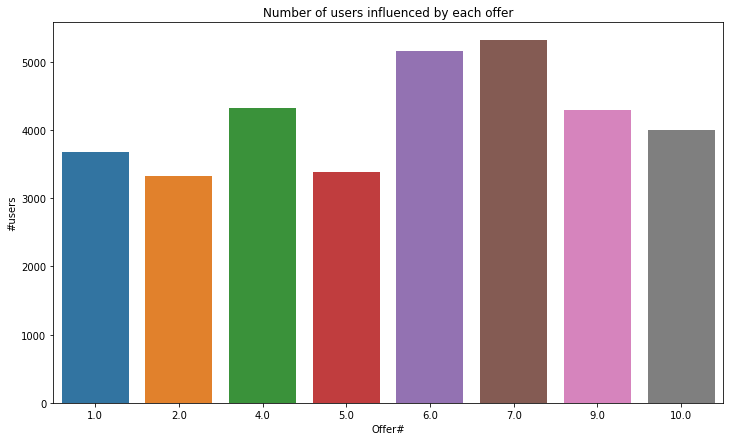

In [55]:
plt.figure(figsize=(12, 7))
sns.countplot(x='offer_id', data= users_sent_viewed_and_completed_offers)
plt.title('Number of users influenced by each offer')
plt.ylabel('#users')
plt.xlabel('Offer#')
plt.xticks(rotation = 0)
plt.show()

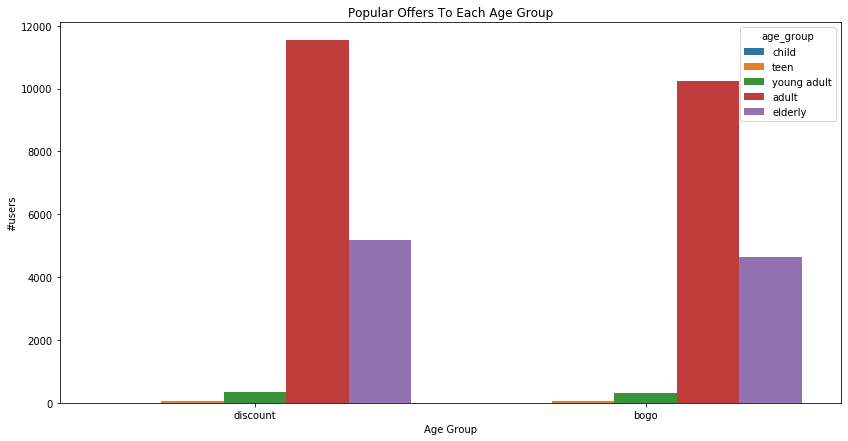

In [56]:
plt.figure(figsize=(14, 7))
sns.countplot(x="offer_type", hue="age_group", data=users_sent_viewed_and_completed_offers)
plt.title('Popular Offers To Each Age Group')
plt.ylabel('#users')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.show()

#### Observations:

- It seems like users are only influenced by 'discount' and 'BOGO' offers.
- All age groups prefer discounts offers in comparison to other offer types, hence, Starbucks should send more discounts offers.

# Modeling Data

## Preparing Data

### adding label 1 in sent_offer column to users who were sent, viewed and completed offers

In [57]:
X1 = users_sent_viewed_and_completed_offers.drop(['id', 'person', 'event', 'time', 'offer_type', 'offer_id', 'amount', 'reward'], axis=1)
X1['sent_offer'] = 1
X1.head()

,gender,age,income,year_joined,age_group,sent_offer
0,M,42.0,96000.0,2016.0,adult,1
1,F,39.0,67000.0,2017.0,adult,1
2,M,52.0,72000.0,2018.0,adult,1
3,M,37.0,92000.0,2017.0,adult,1
4,M,48.0,62000.0,2015.0,adult,1


### Getting users who weren't sent offers and adding label 0 in sent_offer column

In [58]:
X2 = profile[~profile['id'].isin(users_sent_viewed_and_completed_offers['person'].tolist())].drop(['id'], axis=1)
X2['sent_offer'] = 0
X2.head()

,gender,age,income,year_joined,age_group,sent_offer
1,F,55,112000.0,2017,adult,0
19,F,61,40000.0,2018,adult,0
28,F,46,59000.0,2017,adult,0
41,F,20,30000.0,2016,young adult,0
59,M,45,48000.0,2017,adult,0


In [59]:
print("There are {} users who were sent offers".format(X1.shape[0]))
print("There are {} users who were NOT sent offers".format(X2.shape[0]))

There are 33466 users who were sent offers
There are 2909 users who were NOT sent offers


**If we used all X1's data, we'd have 33466 users who were sent offers, and only 2839 users who were NOT sent offers, and that would make our dataset biased, so, we will use a subset of those to debias it.**

### Combining the users

Who were sent offers and those who were not into one data frame to construct our data.

Sampling only 4000 user from users who recieved, viewed and completed offers to avoid class imbalance issues.

In [60]:
Data = pd.concat([X1.sample(4000),X2]).sample(frac=1, random_state=20)
Data['gender'].value_counts()

M    4053
F    2634
O      94
Name: gender, dtype: int64

In [61]:
Data.head()

,gender,age,income,year_joined,age_group,sent_offer
14094,M,23.0,38000.0,2014.0,adult,0
13948,M,22.0,66000.0,2017.0,adult,0
11951,M,72.0,71000.0,2017.0,elderly,0
1257,F,71.0,93000.0,2016.0,elderly,1
22511,M,62.0,85000.0,2018.0,adult,1


### Dropping missing values if any

In [62]:
Data.dropna(inplace=True)

### encoding the categorcal variables 

In [63]:
Data = pd.get_dummies(Data,columns=["gender","year_joined","age_group"],prefix="",prefix_sep="")
Data.head()

,age,income,sent_offer,F,M,O,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,child,teen,young adult,adult,elderly
14094,23.0,38000.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
13948,22.0,66000.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
11951,72.0,71000.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1257,71.0,93000.0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1
22511,62.0,85000.0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0


### Normalizing age and income

In [64]:
scaler = MinMaxScaler()
to_normalize = ["income","age"]
Data[to_normalize] = scaler.fit_transform(Data[to_normalize])

In [65]:
Data.head()

,age,income,sent_offer,F,M,O,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,child,teen,young adult,adult,elderly
14094,0.060241,0.088889,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
13948,0.048193,0.400000,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
11951,0.650602,0.455556,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1257,0.638554,0.700000,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1
22511,0.530120,0.611111,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0


### Constructing X and y
X for features and y for lables

In [66]:
X = np.array(Data.drop('sent_offer',axis=1).values.tolist())
y = Data["sent_offer"].values.tolist()

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Defining model functions 

### Model fitting

In [71]:
def fit_RF(X_train, y_train):  
    
    '''
    Fits a Random Forest Classifier with GridSearchCV
    
    INPUTS:
    
        X_train: training features
        y_train: training lables
    
    RETURNS:
    
        clf: Random Forest object
        
    '''
    scorer = make_scorer(fbeta_score , beta = 0.5)
    
    # number of trees in the random forest
    n_estimators = [10,30,50,100,150,200,250,300]
    
    # number of features to consider at every split
    max_features = ["auto" , "sqrt"]
    
    # minimum number of samples required to split the node
    min_samples_split = [2,5,10]
    
    # minimum number required at each leaf
    min_samples_leaf = [1,2,4]
    
    # grid params
    parameters = {'n_estimators': [300, 350, 400, 450, 500],
                  'max_depth': [10, 11, 12, 13, 14, 15],
                  'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split,
                  'random_state': [0]}
    # Gridsearch object
    clf = GridSearchCV(RandomForestClassifier(),
                       parameters ,
                       scoring = scorer ,
                       cv=5 ,
                       verbose = 2 ,
                       n_jobs=-1)
    
    # fitting the GridSearch object
    clf.fit(X_train, y_train)
    
    return clf   # returning the classifier/GridSearch object
        

### Model Evaluation

#### Evaluation metrics

-  **Precision** is the measure of the correctly identified positive cases from all the predicted positive cases. Thus, it is useful when the costs of False Positives is high.

![Precision](./Pics/1.png)

- **Recall** is the measure of the correctly identified positive cases from all the actual positive cases. It is important when the cost of False Negatives is high.

![Recall](./Pics/2.png)

- **Accuracy** is the measure of all the correctly identified cases. It is most used when all the classes are equally important.

![Accuracy](./Pics/3.png)

- **F1-score** is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.
    - We use the Harmonic Mean since it penalizes the extreme values.
    
![F1-score](./Pics/4.png)


**We will use Accuracy and F1-score, but mostly F1-score because we care about False Negatives and False Positives**

- False Negatives: user that should've received an offer but didn't.
- False Positives: user that should NOT have received an offer but did.

In [72]:
def evaluate_model_performance(clf, X_train, y_train):
    
    '''
    Prints model's accuracy and F1-score
    
    INPUTS:
    
        clf: model object
        X_train: features
        y_train: lables
    
    RETURNS:
    
        clf_accuracy: model's accuracy
        clf_f1_score: model's F1-score
    '''
    # extracting model name
    class_name = re.sub("[<>']", '', str(clf.estimator.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]
    
    # predicting lables of training set
    y_pred_rf = clf.predict(X_train)
    
    # predicting lables of testing set
    test_preds = clf.predict(X_test)
    
    # calculating accuracy of training set
    clf_accuracy = accuracy_score(y_train,y_pred_rf)
    # calculating f1-score of training set
    clf_f1_score = f1_score(y_train,y_pred_rf)
    
    # calculating accuracy of testing set
    test_accuracy = accuracy_score(y_test, test_preds)
    # calculating f1-score of training set
    test_f1_score = f1_score(y_test, test_preds)
    
    
    print("%s model's accuracy on training data: %.3f" % (class_name, clf_accuracy))
    print("%s model's accuracy on testing data: %.3f" % (class_name, test_accuracy))
    print()
    print("%s model's f1-score on training data: %.3f" % (class_name, clf_f1_score))
    print("%s model's f1-score on testing data: %.3f" % (class_name, test_f1_score))

## Fitting Random Forest Classifier

In [73]:
clf = fit_RF(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 16.8min finished


## Evaluating The Random Forest Classifier

In [75]:
evaluate_model_performance(clf, X_train, y_train)

RandomForestClassifier model's accuracy on training data: 0.793
RandomForestClassifier model's accuracy on testing data: 0.723

RandomForestClassifier model's f1-score on training data: 0.815
RandomForestClassifier model's f1-score on testing data: 0.757


**Our classifier had a f1-score of about 0.80 on training set, and 0.77 on the test set.**

**Close numbers indicate a low possibility of overfitting; model didn't overfit the data.**

**Note:** Numbers may slightly differ because of the random subset of the data (4000 record)

## Plot Estimated Feature Importance

**Feature importance** is a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric.

Text(0.5, 1.0, 'Random Forest Estimated Feature Importance')

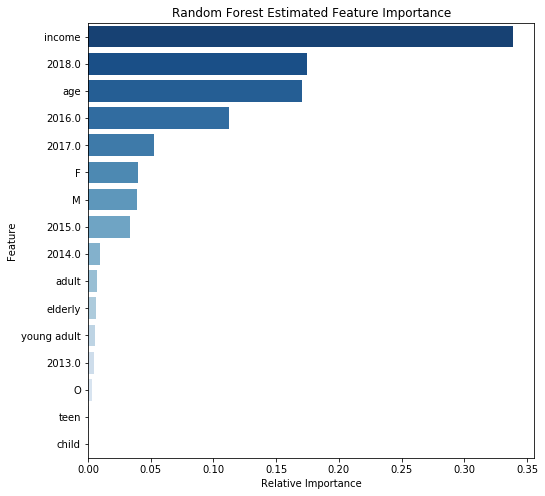

In [76]:
# getting features' names
variables_names = Data.drop(['sent_offer'], axis=1).columns.values

# getting features importance
relative_importance = clf.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

#creating a dataframe of features and their relative importance
feature_importance = pd.DataFrame(list(zip(variables_names, relative_importance)), columns=['feature', 'relativeimportance'])

# sorting values descendingly to determine the best features
feature_importance = feature_importance.sort_values('relativeimportance', ascending=False)

# resetting index
feature_importance = feature_importance.reset_index(drop=True)

# defining color palette
palette = sns.color_palette("Blues_r", feature_importance.shape[0])

# plot
plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance', y='feature', data=feature_importance, palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

**Our RandomForestClassifier suggests that these are the relative feature importance**

### Top 3 features:

- User's income  
- User's age
- Whether the user joined Starbucks rewards mobile application in 2018 or not.

# Results & Possible improvements:

These features are associated with the user, so, Starbucks may choose to do further analysis to determine how user's income affects purchases. (example: map users' income into categories [low, medium, high] and low-income users get more offers)


**During our analysis for users_sent_viewed_and_completed_offers we noticed that:**


- Most users who completed offers were males, so we might consider sending more offers to them.
- Offers 7 and 6 have the highest completion counts, so Starbucks should send these offers more frequently.
- Users are only influenced by 'discount' and 'BOGO' offers, so Starbucks should focus more on those.
- All age groups prefer discounts offers in comparison to other offer types, hence, Starbucks should send more discounts offers.

**ML model can be improved by adding more data or further tuning the model.**

# Conclusion

In this project, I tried to analyze the data and make a model to determine which users should Starbucks send offers to.


First I explored the data and did some data wrangling to help my analysis, then I did some exploratory analysis on the data after cleaning.


In conclusion, the company should give more offers to Males since they have more completed offers. And they should focus on Discount offers since they are the most common types.